In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from datetime import datetime
import time
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

In [2]:
data  = pd.read_csv('../Data/earthquake_dataset.csv')
data.head()

,Time,Latitude,Longitude,Depth/Km,Magnitude,EventLocationName
0,2010-10-13T21:41:46.570000,42.623,12.756,10.5,1.7,3 km W Ferentillo (TR)
1,2010-10-13T21:43:14.530000,42.457,13.390,10.8,1.7,8 km E Pizzoli (AQ)
2,2010-10-13T23:35:35.700000,42.470,13.377,11.0,0.8,8 km E Pizzoli (AQ)
3,2010-10-13T23:44:28.160000,42.474,13.393,12.9,1.3,9 km E Pizzoli (AQ)
4,2010-10-13T23:46:11.610000,42.448,13.387,10.2,2.0,8 km E Pizzoli (AQ)


## Feature engineering
Converts 'Time' to the following features:
- Year
- Month = $\{1,...12\}$
- Day = $\{1,...,31\}$
- DayTime = $\{0,1,2\}$ 

In [4]:
dates = [datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f') for x in data['Time']]
time_s = [int(time.mktime(d.timetuple()) / (60*60*24)) for d in dates]  # days since epoch

years = [d.year for d in dates]
months = [d.month for d in dates]
days = [d.day for d in dates]
hours = [d.hour for d in dates]

# TODO: maybe use this
day_time = []
for h in hours:
    if h >= 0 and h <8: # morning
        day_time.append(0)
    elif h >= 8 and h < 16: # afternoon
        day_time.append(1)
    elif h >= 16 or h <= 23:
        day_time.append(2)
    

data['Year'] = years
data['Month'] = months
data['Day'] = days
data['Hour'] = hours 
# TODO: maybe use this
data['DayTime'] = day_time
data['Time/d'] = time_s

# select features
features = ['Latitude', 'Longitude', 'Depth/Km', 'Magnitude', 'Time/d'] # 'Year', 'Month', 'Day']#, 'Hour']
data[features].head()

,Latitude,Longitude,Depth/Km,Magnitude,Time/d
0,42.623,12.756,10.5,1.7,14895
1,42.457,13.390,10.8,1.7,14895
2,42.470,13.377,11.0,0.8,14895
3,42.474,13.393,12.9,1.3,14895
4,42.448,13.387,10.2,2.0,14895


## Create dataset

In [10]:
X_data = data[features].values
X_data.shape

(29969, 5)

#### Preprocessing

In [11]:
standardizer = StandardScaler()
X_data = standardizer.fit_transform(X_data)

#### Train / Validation / Test split

In [12]:
# split between train and validation
tr_size = int(0.7 * len(X_data))
vl_size = int(0.2 * len(X_data))
ts_size = int(0.1 * len(X_data))

X_data_train, X_data_val, X_data_test = X_data[:tr_size,:], X_data[tr_size:tr_size+vl_size,:], X_data[-ts_size:,:]

In [13]:
def create_dataset(dataset, look_back=1):
    """
    creates pairs of past 'look_back' sequences and next target sequence
    """
    X, Y = [], []
    to_predict = ['Latitude', 'Longitude', 'Magnitude', 'Time/s']
    for i in range(len(dataset)-look_back-1):
        sequences = dataset[i:(i+look_back)]
        target_sequence = dataset[i + look_back:i+look_back+1][:, [0,1,3,4]] # do not predict depth
        X.append(np.array(sequences))
        Y.append(np.array(target_sequence))
        
    return np.array(X), np.array(Y)

In [14]:
look_back = 50

X_train, Y_train = create_dataset(X_data_train, look_back)
X_val, Y_val = create_dataset(X_data_val, look_back)
X_test, Y_test = create_dataset(X_data_test, look_back)

print (X_train.shape, Y_train.shape)

((20927, 50, 5), (20927, 1, 4))


#### Loss function

In [44]:
def custom_objective(y_true, y_pred):
    square = K.square(y_pred[:2] - y_true[:2])
    a = K.sqrt(K.mean(square, axis=-1))
    b = 5#K.sum(K.abs(y_true[:, 2:] - y_pred[:, 2:]), axis=-1)
    return (a + b) / 5 

### Training callbacks

In [17]:
filepath = '../models/model.{epoch:02d}-{val_loss:.5f}.hdf5'
model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False)

# Model definition

In [54]:
n_inputs = X_train.shape[2]
n_outputs = Y_train.shape[2]

model = Sequential()

model.add(LSTM(
    input_dim=n_inputs,
    output_dim=128,
    return_sequences=True))
model.add(Dropout(0.1))

#model.add(LSTM(
#    output_dim=64,
#    return_sequences=True))
#model.add(Dropout(0.2))

model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(n_outputs))

model.compile(loss='mse', optimizer='adam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, None, 128)         68608     
_________________________________________________________________
dropout_18 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
dense_25 (Dense)             (None, None, 32)          4128      
_________________________________________________________________
dense_26 (Dense)             (None, None, 4)           132       
Total params: 72,868
Trainable params: 72,868
Non-trainable params: 0
_________________________________________________________________


/home/carlo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  if __name__ == '__main__':
/home/carlo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=128, return_sequences=True, input_shape=(None, 5))`
  if __name__ == '__main__':


In [51]:
epochs = 20
batch_size = 10

history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    verbose=1, 
                    callbacks=[model_checkpoint],
                    epochs=epochs,
                    validation_data=(X_val, Y_val),
                    shuffle=False)

Train on 20927 samples, validate on 5942 samples
Epoch 1/20
20927/20927 [==============================] - 135s 6ms/step - loss: 0.8432 - val_loss: 0.4513
Epoch 2/20
20927/20927 [==============================] - 138s 7ms/step - loss: 0.8374 - val_loss: 0.4504
Epoch 3/20
20927/20927 [==============================] - 140s 7ms/step - loss: 0.8352 - val_loss: 0.4504
Epoch 4/20
20927/20927 [==============================] - 137s 7ms/step - loss: 0.8352 - val_loss: 0.4505
Epoch 5/20
20927/20927 [==============================] - 131s 6ms/step - loss: 0.8349 - val_loss: 0.4503
Epoch 6/20
20927/20927 [==============================] - 133s 6ms/step - loss: 0.8342 - val_loss: 0.4495
Epoch 7/20
20927/20927 [==============================] - 138s 7ms/step - loss: 0.8353 - val_loss: 0.4500
Epoch 8/20
20927/20927 [==============================] - 141s 7ms/step - loss: 0.8361 - val_loss: 0.4498
Epoch 9/20
20927/20927 [==============================] - 135s 6ms/step - loss: 0.8352 - val_loss: 0.44

### Learning curve plot

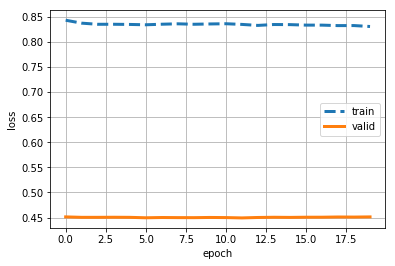

In [52]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, linewidth=3, label='train', linestyle='--')
plt.plot(val_loss, linewidth=3, label='valid')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(1e-3, 1e-2)
#plt.yscale('log') 
#plt.savefig()
#plt.title('Learning Curve Training vs Validation')
plt.show()

In [64]:
model.evaluate(X_test, Y_test)

2945/2945 [==============================] - 7s 2ms/step


0.49773906211294422